## 1. Import Libraries

In [1]:
# Data manipulation
import sys
import subprocess
import importlib
import json
import csv
import gc
import time
import warnings
from pathlib import Path

import pandas as pd
import numpy as np

warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch

# Ensure accelerate is available BEFORE importing/using Trainer/TrainingArguments
def _ensure_accelerate():
    try:
        import accelerate
        return accelerate
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "accelerate>=0.26.0"])
        importlib.invalidate_caches()
        import accelerate
        return accelerate

accelerate = _ensure_accelerate()
print("⚙️ accelerate:", getattr(accelerate, "__version__", "unknown"))

# Defensive reload: if transformers was imported before accelerate was installed, or if a previous import was partial,
# modules may be missing required symbols in the current kernel session.
import transformers
import transformers.training_args as _training_args_mod
import transformers.trainer as _trainer_mod
import transformers.modeling_utils as _modeling_utils_mod

_needs_reload = (
    (not hasattr(_training_args_mod, "AcceleratorConfig"))
    or (not hasattr(_trainer_mod, "DataLoaderConfiguration"))
    or (not hasattr(_modeling_utils_mod, "extract_model_from_parallel"))
 )
if _needs_reload:
    import transformers.utils.import_utils as _import_utils
    importlib.reload(_import_utils)
    importlib.reload(_training_args_mod)
    importlib.reload(_trainer_mod)
    importlib.reload(_modeling_utils_mod)

# HuggingFace libraries
from datasets import Dataset, DatasetDict

# Import these directly from their defining modules to avoid stale references if transformers modules were reloaded.
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers.training_args import TrainingArguments
from transformers.trainer import Trainer
from transformers.trainer_callback import EarlyStoppingCallback

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# Select device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'🐍 Python: {sys.executable}')
print(f'🖥️ Using device: {device}')

⚙️ accelerate: 1.12.0
🐍 Python: c:\Anaconda\envs\py310\python.exe
🖥️ Using device: cuda


## 2. Load Preprocessed Dataset

In [2]:
# Define paths
DATA_DIR = Path("./data")
MODELS_DIR = Path("./models")
BERT_MODELS_DIR = MODELS_DIR / "bert_models"
BERT_MODELS_DIR.mkdir(exist_ok=True, parents=True)

INPUT_FILE = DATA_DIR / "english_clean.csv"

print(f"📂 Data directory: {DATA_DIR.resolve()}")
print(f"📂 Models directory: {BERT_MODELS_DIR.resolve()}")
print(f"📄 Input file: {INPUT_FILE.name}")

📂 Data directory: C:\Users\Nguyen Ngo\Downloads\NLP PApere\NLP-Trade-Message\data
📂 Models directory: C:\Users\Nguyen Ngo\Downloads\NLP PApere\NLP-Trade-Message\models\bert_models
📄 Input file: english_clean.csv


In [3]:
# Load dataset
df = pd.read_csv(INPUT_FILE)

print(f"✅ Loaded dataset: {len(df):,} records")
print(f"\n📊 Dataset shape: {df.shape}")
print(f"\n🔍 Columns: {df.columns.tolist()}")

# Remove rows with missing critical data
df = df.dropna(subset=['clean_text', 'label'])
print(f"\n📊 Final dataset size: {len(df):,} records")

# Display label distribution
print("\n🏷️  Label distribution:")
print(df['label'].value_counts())

df.head()

✅ Loaded dataset: 1,334 records

📊 Dataset shape: (1334, 9)

🔍 Columns: ['title', 'url', 'root_category', 'subcategory', 'label', 'combined_text', 'clean_text', 'word_count', 'timestamp']

📊 Final dataset size: 1,334 records

🏷️  Label distribution:
label
drug       607
fraud      452
guide      134
other       96
hacking     45
Name: count, dtype: int64


,title,url,root_category,subcategory,label,combined_text,clean_text,word_count,timestamp
0,USA FULLZ + DL + BACKGROUND REPORT MONTANA | N...,http://nemesis555nchzn2dogee6mlc7xxgeeshqirmh3...,Fraud,SSN/DOB/DL/PII,fraud,USA FULLZ + DL + BACKGROUND REPORT MONTANA | N...,usa fullz dl background report montana nemesis...,23,2023-01-11T13:00:52
1,1 x POWER PLANT XL autoflower seed | Nemesis M...,http://nemesis555nchzn2dogee6mlc7xxgeeshqirmh3...,Drugs,Cannabis,drug,1 x POWER PLANT XL autoflower seed | Nemesis M...,1 x power plant xl autoflower seed nemesis mar...,189,2023-01-11T13:00:01
2,Ship Marijuana Safely - Instant Delivery | Nem...,http://nemesis555nchzn2dogee6mlc7xxgeeshqirmh3...,Other,Guides and Tutorials,guide,Ship Marijuana Safely - Instant Delivery | Nem...,ship marijuana safely instant delivery nemesis...,142,2023-01-11T12:59:34
3,1x Feminized AUTOFLOWER AK-47 Cannabis Seeds |...,http://nemesis555nchzn2dogee6mlc7xxgeeshqirmh3...,Drugs,Cannabis,drug,1x Feminized AUTOFLOWER AK-47 Cannabis Seeds |...,1x feminized autoflower ak 47 cannabis seeds n...,178,2023-01-11T12:59:08
4,1 x KALASHNIKOV autoflower seed | Nemesis Market,http://nemesis555nchzn2dogee6mlc7xxgeeshqirmh3...,Drugs,Cannabis,drug,1 x KALASHNIKOV autoflower seed | Nemesis Mark...,1 x kalashnikov autoflower seed nemesis market...,170,2023-01-11T12:58:53


## 3. Prepare Data for BERT

### 3.1 Encode Labels

In [4]:
# Encode labels to numeric values
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Create label mappings
label2id = {label: idx for idx, label in enumerate(label_encoder.classes_)}
id2label = {idx: label for label, idx in label2id.items()}

num_labels = len(label_encoder.classes_)

print(f"📊 Number of classes: {num_labels}")
print(f"\n🏷️  Label mappings:")
for label, idx in label2id.items():
    count = (df['label'] == label).sum()
    print(f"   {idx}: {label:15s} ({count:4d} samples)")

# Save label encoder
import pickle
with open(BERT_MODELS_DIR / 'label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print(f"\n💾 Saved label encoder to: label_encoder.pkl")

📊 Number of classes: 5

🏷️  Label mappings:
   0: drug            ( 607 samples)
   1: fraud           ( 452 samples)
   2: guide           ( 134 samples)
   3: hacking         (  45 samples)
   4: other           (  96 samples)

💾 Saved label encoder to: label_encoder.pkl


### 3.2 Train/Validation/Test Split

In [5]:
# Prepare features and labels
# Use 'combined_text' if available (title + description), otherwise 'clean_text'
text_column = 'combined_text' if 'combined_text' in df.columns else 'clean_text'
print(f"📝 Using text column: {text_column}")

X = df[text_column].values
y = df['label_encoded'].values

# First split: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.30, 
    random_state=RANDOM_STATE, 
    stratify=y
)

# Second split: validation (15%) and test (15%) from temp (30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.50, 
    random_state=RANDOM_STATE, 
    stratify=y_temp
)

print("✅ Data split complete!")
print(f"\n📊 Split sizes:")
print(f"   Train:      {len(X_train):4d} ({len(X_train)/len(X)*100:5.2f}%)")
print(f"   Validation: {len(X_val):4d} ({len(X_val)/len(X)*100:5.2f}%)")
print(f"   Test:       {len(X_test):4d} ({len(X_test)/len(X)*100:5.2f}%)")

📝 Using text column: combined_text
✅ Data split complete!

📊 Split sizes:
   Train:       933 (69.94%)
   Validation:  200 (14.99%)
   Test:        201 (15.07%)


### 3.3 Create HuggingFace Datasets

In [6]:
# Create dataset dictionaries
train_dict = {'text': X_train.tolist(), 'label': y_train.tolist()}
val_dict = {'text': X_val.tolist(), 'label': y_val.tolist()}
test_dict = {'text': X_test.tolist(), 'label': y_test.tolist()}

# Create HuggingFace datasets
train_dataset = Dataset.from_dict(train_dict)
val_dataset = Dataset.from_dict(val_dict)
test_dataset = Dataset.from_dict(test_dict)

# Create DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

print("✅ HuggingFace datasets created!")
print(f"\n📊 Dataset structure:")
print(dataset_dict)

# Sample from train dataset
print(f"\n📋 Sample from training set:")
sample = train_dataset[0]
print(f"   Text: {sample['text'][:200]}...")
print(f"   Label: {sample['label']} ({id2label[sample['label']]})")

✅ HuggingFace datasets created!

📊 Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 933
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 201
    })
})

📋 Sample from training set:
   Text: Bank Transfers For Beginners | 100% Working! | Nemesis Market. This is a guide on how to do bank transfers and make huuggee money with it. Also for beginners. All my items are tested and working 100%....
   Label: 2 (guide)


## 4. Tokenization

We'll prepare tokenizers for all three models but start with BERT.

In [7]:
# Define model checkpoints (main + lightweight for comparison)
MODEL_CHECKPOINTS = {
    # Main backbones
    'BERT': 'bert-base-uncased',
    'RoBERTa': 'roberta-base',
    'XLM-RoBERTa': 'xlm-roberta-base',
    # Lightweight / small backbones
    'DistilBERT': 'distilbert-base-uncased',
    'DistilRoBERTa': 'distilroberta-base',
    'ELECTRA-Small': 'google/electra-small-discriminator',
    'BERT-Tiny': 'prajjwal1/bert-tiny',
    'BERT-Mini': 'prajjwal1/bert-mini',
    'BERT-Small': 'prajjwal1/bert-small',
}

# Run profile presets: choose one
#   - FAST: quick smoke-test (1 epoch + optional subsample)
#   - COMPARE: fair comparison across main vs lightweight (fixed max_length, more epochs, no checkpoint overhead)
#   - PAPER: slower, saves best checkpoints, allows early stopping
RUN_PROFILE = 'COMPARE'  # 'FAST' | 'COMPARE' | 'PAPER'

FAST_MODE = RUN_PROFILE.upper() == 'FAST'
COMPARE_MODE = RUN_PROFILE.upper() == 'COMPARE'
PAPER_MODE = RUN_PROFILE.upper() == 'PAPER'

# FAST preset
FAST_MAX_LENGTH = 128
FAST_NUM_EPOCHS = 1
FAST_TRAIN_BATCH_SIZE = 8
FAST_EVAL_BATCH_SIZE = 16
FAST_MAX_TRAIN_SAMPLES = 2000
FAST_MAX_EVAL_SAMPLES = 500

# COMPARE preset (recommended for main vs lightweight comparison)
COMPARE_MAX_LENGTH = 128
COMPARE_NUM_EPOCHS = 3
COMPARE_TRAIN_BATCH_SIZE = 8
COMPARE_EVAL_BATCH_SIZE = 16
COMPARE_MAX_TRAIN_SAMPLES = None  # set an int to subsample, or None for full train split
COMPARE_MAX_EVAL_SAMPLES = None   # set an int to subsample, or None for full val/test splits

# PAPER preset (heavier, saves checkpoints)
PAPER_NUM_EPOCHS = 3
PAPER_TRAIN_BATCH_SIZE = 16
PAPER_EVAL_BATCH_SIZE = 32

# Choose which model to fine-tune in this notebook section
current_model_name = 'RoBERTa'  # e.g. 'BERT', 'DistilRoBERTa', 'ELECTRA-Small'
model_checkpoint = MODEL_CHECKPOINTS[current_model_name]

print(f"🤖 Loading tokenizer for: {current_model_name}")
print(f"   Checkpoint: {model_checkpoint}")
print(f"🎛️  RUN_PROFILE: {RUN_PROFILE}")

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

print(f"\n✅ Tokenizer loaded successfully!")
print(f"   Vocab size: {tokenizer.vocab_size:,}")
print(f"   Max length: {tokenizer.model_max_length}")

🤖 Loading tokenizer for: RoBERTa
   Checkpoint: roberta-base
🎛️  RUN_PROFILE: COMPARE

✅ Tokenizer loaded successfully!
   Vocab size: 50,265
   Max length: 512


In [9]:
# Test tokenization
sample_text = train_dataset[0]['text']
print(f"📝 Sample text: {sample_text[:200]}...\n")

tokens = tokenizer(sample_text, truncation=True, padding=True)
print(f"🔤 Tokenized output:")
print(f"   Input IDs length: {len(tokens['input_ids'])}")
print(f"   Tokens: {tokenizer.convert_ids_to_tokens(tokens['input_ids'][:20])}...")

📝 Sample text: Bank Transfers For Beginners | 100% Working! | Nemesis Market. This is a guide on how to do bank transfers and make huuggee money with it. Also for beginners. All my items are tested and working 100%....

🔤 Tokenized output:
   Input IDs length: 88
   Tokens: ['<s>', 'Bank', 'ĠTrans', 'f', 'ers', 'ĠFor', 'ĠBegin', 'ners', 'Ġ|', 'Ġ100', '%', 'ĠWorking', '!', 'Ġ|', 'ĠNemesis', 'ĠMarket', '.', 'ĠThis', 'Ġis', 'Ġa']...


📊 Text length statistics (token counts):
   Mean:   172.0 tokens
   Median: 167 tokens
   95th percentile: 324 tokens
   99th percentile: 443 tokens
   Max:    512 tokens

🎯 Using max_length: 128 tokens


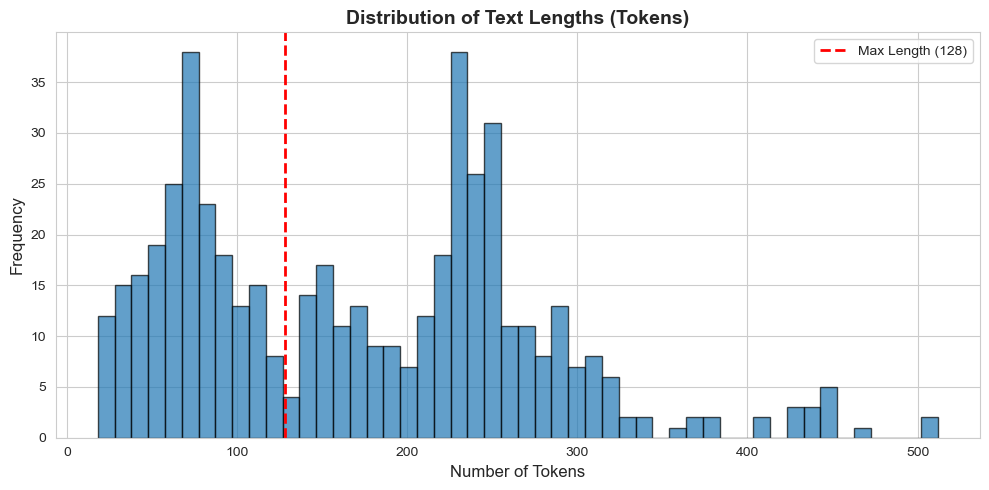

In [21]:
# Analyze text lengths to determine optimal max_length
text_lengths = [len(tokenizer.encode(text, truncation=True, max_length=512)) for text in X_train[:500]]  # Sample 500 for speed

print(f"📊 Text length statistics (token counts):")
print(f"   Mean:   {np.mean(text_lengths):.1f} tokens")
print(f"   Median: {np.median(text_lengths):.0f} tokens")
print(f"   95th percentile: {np.percentile(text_lengths, 95):.0f} tokens")
print(f"   99th percentile: {np.percentile(text_lengths, 99):.0f} tokens")
print(f"   Max:    {np.max(text_lengths)} tokens")

# Default max_length based on data (paper-style)
MAX_LENGTH = min(int(np.percentile(text_lengths, 95)), 512)  # model max is 512
if FAST_MODE:
    MAX_LENGTH = int(FAST_MAX_LENGTH)
elif COMPARE_MODE:
    MAX_LENGTH = int(COMPARE_MAX_LENGTH)

print(f"\n🎯 Using max_length: {MAX_LENGTH} tokens")

# Visualize distribution
plt.figure(figsize=(10, 5))
plt.hist(text_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(MAX_LENGTH, color='red', linestyle='--', linewidth=2, label=f'Max Length ({MAX_LENGTH})')
plt.xlabel('Number of Tokens', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Text Lengths (Tokens)', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=MAX_LENGTH,
    )

# Tokenize all datasets
print("🔄 Tokenizing datasets...")
tokenized_datasets = dataset_dict.map(
    tokenize_function,
    batched=True,
    desc="Tokenizing",
)

# Optional subsampling for iteration speed
if FAST_MODE:
    tokenized_datasets['train'] = tokenized_datasets['train'].select(range(min(len(tokenized_datasets['train']), int(FAST_MAX_TRAIN_SAMPLES))))
    tokenized_datasets['validation'] = tokenized_datasets['validation'].select(range(min(len(tokenized_datasets['validation']), int(FAST_MAX_EVAL_SAMPLES))))
    tokenized_datasets['test'] = tokenized_datasets['test'].select(range(min(len(tokenized_datasets['test']), int(FAST_MAX_EVAL_SAMPLES))))
elif COMPARE_MODE:
    if COMPARE_MAX_TRAIN_SAMPLES is not None:
        tokenized_datasets['train'] = tokenized_datasets['train'].select(range(min(len(tokenized_datasets['train']), int(COMPARE_MAX_TRAIN_SAMPLES))))
    if COMPARE_MAX_EVAL_SAMPLES is not None:
        tokenized_datasets['validation'] = tokenized_datasets['validation'].select(range(min(len(tokenized_datasets['validation']), int(COMPARE_MAX_EVAL_SAMPLES))))
        tokenized_datasets['test'] = tokenized_datasets['test'].select(range(min(len(tokenized_datasets['test']), int(COMPARE_MAX_EVAL_SAMPLES))))

print("\n✅ Tokenization complete!")
print(f"\n📊 Tokenized dataset structure:")
print(tokenized_datasets)

# Inspect tokenized sample
print(f"\n📋 Tokenized sample:")
print(f"   Keys: {tokenized_datasets['train'][0].keys()}")
print(f"   Input IDs shape: {len(tokenized_datasets['train'][0]['input_ids'])}")

🔄 Tokenizing datasets...


Tokenizing: 100%|██████████| 201/201 [00:00<00:00, 4895.68 examples/s]


✅ Tokenization complete!

📊 Tokenized dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 933
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 201
    })
})

📋 Tokenized sample:
   Keys: dict_keys(['text', 'label', 'input_ids', 'attention_mask'])
   Input IDs shape: 128


## 5. Fine-tune BERT

### 5.1 Load Pre-trained Model

In [10]:
# Load pre-trained model for sequence classification
print(f"🤖 Loading {current_model_name} model for sequence classification...")

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

# Move model to device
model.to(device)

print(f"\n✅ Model loaded successfully!")
print(f"   Parameters: {model.num_parameters():,}")
print(f"   Device: {next(model.parameters()).device}")

🤖 Loading RoBERTa model for sequence classification...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✅ Model loaded successfully!
   Parameters: 124,649,477
   Device: cuda:0


### 5.2 Define Evaluation Metrics

In [8]:
# Define compute_metrics function for Trainer
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='macro', zero_division=0
    )
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

print("✅ Metrics function defined!")

✅ Metrics function defined!


### 5.3 Configure Training Arguments

In [22]:
# Define output directory
profile_suffix = f"_{RUN_PROFILE.lower()}"
output_dir = BERT_MODELS_DIR / f"{current_model_name.lower()}_finetuned{profile_suffix}"

# Profile-aware defaults
if FAST_MODE:
    run_num_epochs = int(FAST_NUM_EPOCHS)
    run_train_bs = int(FAST_TRAIN_BATCH_SIZE)
    run_eval_bs = int(FAST_EVAL_BATCH_SIZE)
    save_strategy = "no"
    load_best = False
    metric_for_best = None
elif COMPARE_MODE:
    run_num_epochs = int(COMPARE_NUM_EPOCHS)
    run_train_bs = int(COMPARE_TRAIN_BATCH_SIZE)
    run_eval_bs = int(COMPARE_EVAL_BATCH_SIZE)
    save_strategy = "no"
    load_best = False
    metric_for_best = None
else:  # PAPER_MODE
    run_num_epochs = int(PAPER_NUM_EPOCHS)
    run_train_bs = int(PAPER_TRAIN_BATCH_SIZE)
    run_eval_bs = int(PAPER_EVAL_BATCH_SIZE)
    save_strategy = "epoch"
    load_best = True
    metric_for_best = "f1"

# Training arguments
training_args = TrainingArguments(
    output_dir=str(output_dir),

    # Training hyperparameters
    num_train_epochs=run_num_epochs,
    per_device_train_batch_size=run_train_bs,
    per_device_eval_batch_size=run_eval_bs,
    learning_rate=2e-5,
    weight_decay=0.01,

    # Evaluation strategy
    eval_strategy="epoch",
    save_strategy=save_strategy,
    load_best_model_at_end=load_best,
    metric_for_best_model=metric_for_best,

    # Logging
    logging_dir=str(output_dir / "logs"),
    logging_steps=50,

    # Keep only 2 best checkpoints (paper mode)
    save_total_limit=2,

    # Reproducibility
    seed=RANDOM_STATE,

    # Performance
    fp16=torch.cuda.is_available(),

    # Disable Weights & Biases logging
    report_to="none",
)

print("🔧 Training arguments configured:")
print(f"   RUN_PROFILE: {RUN_PROFILE}")
print(f"   Epochs: {training_args.num_train_epochs}")
print(f"   Batch size (train): {training_args.per_device_train_batch_size}")
print(f"   Batch size (eval): {training_args.per_device_eval_batch_size}")
print(f"   Max length: {MAX_LENGTH}")
print(f"   FP16: {training_args.fp16}")
print(f"   Output dir: {output_dir.name}")

🔧 Training arguments configured:
   RUN_PROFILE: COMPARE
   Epochs: 3
   Batch size (train): 8
   Batch size (eval): 16
   Max length: 128
   FP16: True
   Output dir: roberta_finetuned_compare


### 5.4 Initialize Trainer

In [27]:
# Initialize Trainer
callbacks = [] if (FAST_MODE or COMPARE_MODE) else [EarlyStoppingCallback(early_stopping_patience=2)]
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=callbacks,
)

print("✅ Trainer initialized!")
print(f"   Total training steps: {len(tokenized_datasets['train']) // training_args.per_device_train_batch_size * training_args.num_train_epochs}")

✅ Trainer initialized!
   Total training steps: 348


### 5.5 Train the Model

In [28]:
# Train the model
print(f"\n🚀 Starting fine-tuning of {current_model_name}...\n")
print("=" * 80)

train_result = trainer.train()

print("\n" + "=" * 80)
print(f"✅ Training complete!\n")

# Print training metrics
print("📊 Training metrics:")
for key, value in train_result.metrics.items():
    print(f"   {key}: {value:.4f}" if isinstance(value, float) else f"   {key}: {value}")


🚀 Starting fine-tuning of RoBERTa...



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.366900,0.385644,0.845000,0.633797,0.728245,0.647647
2,0.241900,0.457603,0.885000,0.789272,0.793877,0.813277
3,0.114900,0.382684,0.895000,0.794741,0.790597,0.803529



✅ Training complete!

📊 Training metrics:
   train_runtime: 654.1833
   train_samples_per_second: 4.2790
   train_steps_per_second: 0.5370
   total_flos: 184116920189184.0000
   train_loss: 0.2533
   epoch: 3.0000


## 6. Model Evaluation

### 6.1 Validation Set Evaluation

In [1]:
# Evaluate on validation set
print("📊 Evaluating on validation set...\n")
val_results = trainer.evaluate(eval_dataset=tokenized_datasets['validation'])

print("=" * 80)
print(f"VALIDATION SET RESULTS - {current_model_name}")
print("=" * 80)
for key, value in val_results.items():
    if isinstance(value, float):
        print(f"   {key:20s}: {value:.4f}")
    else:
        print(f"   {key:20s}: {value}")
print("=" * 80)

📊 Evaluating on validation set...



NameError: name 'trainer' is not defined

### 6.2 Test Set Evaluation

In [18]:
# Evaluate on test set
print("\n📊 Evaluating on test set...\n")
test_results = trainer.evaluate(eval_dataset=tokenized_datasets['test'])

print("=" * 80)
print(f"TEST SET RESULTS - {current_model_name}")
print("=" * 80)
for key, value in test_results.items():
    if isinstance(value, float):
        print(f"   {key:20s}: {value:.4f}")
    else:
        print(f"   {key:20s}: {value}")
print("=" * 80)


📊 Evaluating on test set...

TEST SET RESULTS - RoBERTa
   eval_loss           : 0.3787
   eval_accuracy       : 0.8756
   eval_f1             : 0.6297
   eval_precision      : 0.6564
   eval_recall         : 0.6427
   eval_runtime        : 13.5912
   eval_samples_per_second: 14.7890
   eval_steps_per_second: 0.9570
   epoch               : 1.0000


### 6.3 Detailed Classification Report

In [19]:
# Get predictions on test set
predictions = trainer.predict(tokenized_datasets['test'])
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Classification report
print("\n" + "=" * 80)
print(f"DETAILED CLASSIFICATION REPORT - {current_model_name} (Test Set)")
print("=" * 80 + "\n")

target_names = [id2label[i] for i in range(num_labels)]
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

100%|██████████| 7/7 [00:56<00:00,  8.11s/it]


DETAILED CLASSIFICATION REPORT - RoBERTa (Test Set)

              precision    recall  f1-score   support

        drug     0.9891    1.0000    0.9945        91
       fraud     0.8750    0.9265    0.9000        68
       guide     0.5926    0.8000    0.6809        20
     hacking     0.0000    0.0000    0.0000         7
       other     0.8000    0.5333    0.6400        15

    accuracy                         0.8856       201
   macro avg     0.6513    0.6520    0.6431       201
weighted avg     0.8625    0.8856    0.8702       201



### 6.4 Confusion Matrix

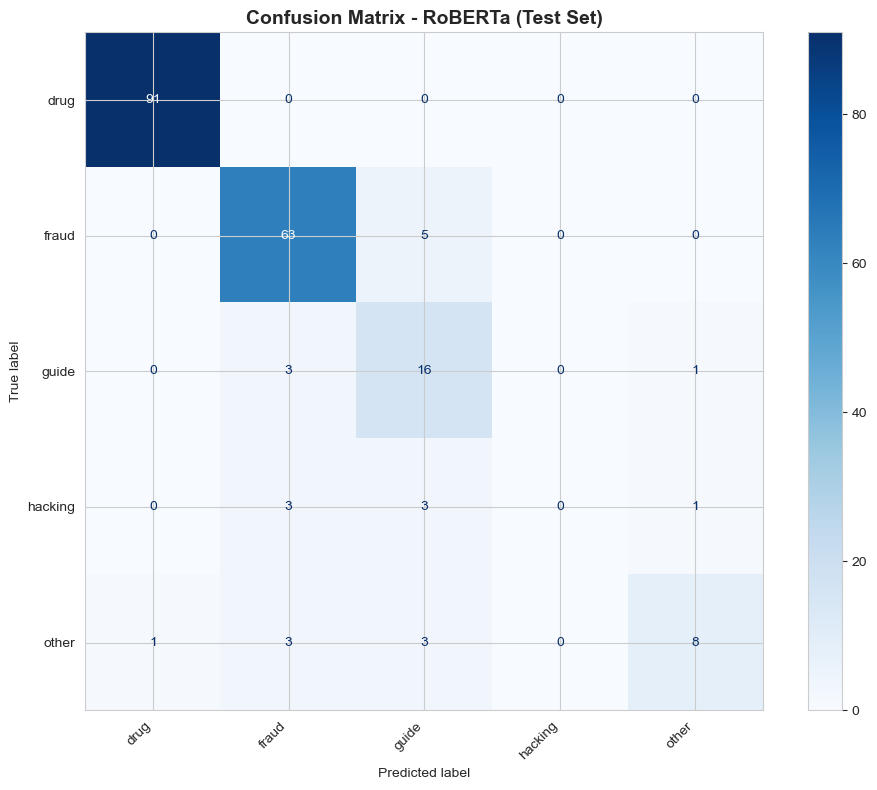


📊 Per-class accuracy:
   drug           : 1.0000 (91/91)
   fraud          : 0.9265 (63/68)
   guide          : 0.8000 (16/20)
   hacking        : 0.0000 (0/7)
   other          : 0.5333 (8/15)


In [20]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title(f'Confusion Matrix - {current_model_name} (Test Set)', 
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(BERT_MODELS_DIR / f'{current_model_name.lower()}_confusion_matrix.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# Per-class accuracy
print("\n📊 Per-class accuracy:")
for i, label in enumerate(target_names):
    class_acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    print(f"   {label:15s}: {class_acc:.4f} ({cm[i, i]}/{cm[i].sum()})")

## 7. Compare with Baseline Models

In [21]:
# Load baseline results if available
baseline_results_path = MODELS_DIR / 'baseline_results.json'

if baseline_results_path.exists():
    with open(baseline_results_path, 'r') as f:
        baseline_data = json.load(f)
    
    # Get best baseline model results
    baseline_test_results = baseline_data['test_results']
    best_baseline = max(baseline_test_results, key=lambda x: x['F1-Score'])
    
    print("📊 Comparison with Baseline Models:\n")
    print("=" * 80)
    print(f"{'Model':<25} {'Accuracy':>12} {'Precision':>12} {'Recall':>12} {'F1-Score':>12}")
    print("=" * 80)
    
    # Best baseline
    print(f"{best_baseline['Model'] + ' (Baseline)':<25} "
          f"{best_baseline['Accuracy']:>12.4f} "
          f"{best_baseline['Precision']:>12.4f} "
          f"{best_baseline['Recall']:>12.4f} "
          f"{best_baseline['F1-Score']:>12.4f}")
    
    # BERT results
    bert_acc = test_results['eval_accuracy']
    bert_f1 = test_results['eval_f1']
    bert_prec = test_results['eval_precision']
    bert_rec = test_results['eval_recall']
    
    print(f"{current_model_name + ' (Fine-tuned)':<25} "
          f"{bert_acc:>12.4f} "
          f"{bert_prec:>12.4f} "
          f"{bert_rec:>12.4f} "
          f"{bert_f1:>12.4f}")
    
    print("=" * 80)
    
    # Calculate improvements
    f1_improvement = ((bert_f1 - best_baseline['F1-Score']) / best_baseline['F1-Score']) * 100
    acc_improvement = ((bert_acc - best_baseline['Accuracy']) / best_baseline['Accuracy']) * 100
    
    print(f"\n🎉 Improvements over best baseline:")
    print(f"   Accuracy:  {acc_improvement:+.2f}%")
    print(f"   F1-Score:  {f1_improvement:+.2f}%")
    
else:
    print("⚠️  Baseline results not found. Run baseline_models.ipynb first.")
    
    # Still show BERT results
    print(f"\n📊 {current_model_name} Test Results:")
    print(f"   Accuracy:  {test_results['eval_accuracy']:.4f}")
    print(f"   Precision: {test_results['eval_precision']:.4f}")
    print(f"   Recall:    {test_results['eval_recall']:.4f}")
    print(f"   F1-Score:  {test_results['eval_f1']:.4f}")

📊 Comparison with Baseline Models:

Model                         Accuracy    Precision       Recall     F1-Score
Linear SVM (Baseline)           0.8607       0.7484       0.6669       0.6969
RoBERTa (Fine-tuned)            0.8856       0.6513       0.6520       0.6431

🎉 Improvements over best baseline:
   Accuracy:  +2.89%
   F1-Score:  -7.72%


## 8. Save Fine-tuned Model

In [19]:
# Save the fine-tuned model and tokenizer
final_model_dir = BERT_MODELS_DIR / f"{current_model_name.lower()}_final"

print(f"💾 Saving fine-tuned model to: {final_model_dir.name}")

trainer.save_model(str(final_model_dir))
tokenizer.save_pretrained(str(final_model_dir))

print("✅ Model and tokenizer saved successfully!")

# Save evaluation results
results_dict = {
    'model_name': current_model_name,
    'model_checkpoint': model_checkpoint,
    'validation_results': val_results,
    'test_results': test_results,
    'training_args': {
        'num_epochs': training_args.num_train_epochs,
        'batch_size': training_args.per_device_train_batch_size,
        'learning_rate': training_args.learning_rate,
        'max_length': MAX_LENGTH
    },
    'label_mappings': {
        'label2id': label2id,
        'id2label': id2label
    }
}

results_file = BERT_MODELS_DIR / f'{current_model_name.lower()}_results.json'
with open(results_file, 'w') as f:
    json.dump(results_dict, f, indent=2)

print(f"💾 Saved evaluation results to: {results_file.name}")

💾 Saving fine-tuned model to: roberta_final
✅ Model and tokenizer saved successfully!
💾 Saved evaluation results to: roberta_results.json


## 9. Summary

In [23]:
# Final summary
print("\n" + "=" * 80)
print(f"{current_model_name} FINE-TUNING SUMMARY")
print("=" * 80)

print(f"\n📁 Dataset:")
print(f"   Total samples: {len(df):,}")
print(f"   Train/Val/Test: {len(X_train)}/{len(X_val)}/{len(X_test)}")
print(f"   Number of classes: {num_labels}")
print(f"   Classes: {', '.join(target_names)}")

print(f"\n🤖 Model:")
print(f"   Architecture: {current_model_name}")
print(f"   Checkpoint: {model_checkpoint}")
print(f"   Parameters: {model.num_parameters():,}")
print(f"   Max sequence length: {MAX_LENGTH} tokens")

print(f"\n🔧 Training:")
print(f"   Epochs: {training_args.num_train_epochs}")
print(f"   Batch size: {training_args.per_device_train_batch_size}")
print(f"   Learning rate: {training_args.learning_rate}")
print(f"   Device: {device}")

print(f"\n📊 Test Results:")
print(f"   Accuracy:  {test_results['eval_accuracy']:.4f}")
print(f"   Precision: {test_results['eval_precision']:.4f}")
print(f"   Recall:    {test_results['eval_recall']:.4f}")
print(f"   F1-Score:  {test_results['eval_f1']:.4f}")

print(f"\n💾 Saved Artifacts:")
print(f"   - Fine-tuned model: {final_model_dir.name}/")
print(f"   - Tokenizer: {final_model_dir.name}/")
print(f"   - Label encoder: label_encoder.pkl")
print(f"   - Results: {results_file.name}")
print(f"   - Confusion matrix: {current_model_name.lower()}_confusion_matrix.png")

print(f"\n🎯 Next Steps:")
print(f"   1. Fine-tune RoBERTa model (change current_model_name to 'RoBERTa')")
print(f"   2. Fine-tune XLM-RoBERTa model (change current_model_name to 'XLM-RoBERTa')")
print(f"   3. Compare all models and select the best one")
print(f"   4. Model interpretation and error analysis")
print(f"   5. Deploy the best model for inference")

print("\n" + "=" * 80)
print(f"✅ {current_model_name} FINE-TUNING COMPLETE!")
print("=" * 80)


RoBERTa FINE-TUNING SUMMARY

📁 Dataset:
   Total samples: 1,334
   Train/Val/Test: 933/200/201
   Number of classes: 5
   Classes: drug, fraud, guide, hacking, other

🤖 Model:
   Architecture: RoBERTa
   Checkpoint: roberta-base
   Parameters: 124,649,477
   Max sequence length: 324 tokens

🔧 Training:
   Epochs: 3
   Batch size: 16
   Learning rate: 2e-05
   Device: cuda

📊 Test Results:
   Accuracy:  0.8856
   Precision: 0.6513
   Recall:    0.6520
   F1-Score:  0.6431

💾 Saved Artifacts:
   - Fine-tuned model: roberta_final/
   - Tokenizer: roberta_final/
   - Label encoder: label_encoder.pkl
   - Results: roberta_results.json
   - Confusion matrix: roberta_confusion_matrix.png

🎯 Next Steps:
   1. Fine-tune RoBERTa model (change current_model_name to 'RoBERTa')
   2. Fine-tune XLM-RoBERTa model (change current_model_name to 'XLM-RoBERTa')
   3. Compare all models and select the best one
   4. Model interpretation and error analysis
   5. Deploy the best model for inference

✅ RoBE

## 10. Training History Visualization (Optional)

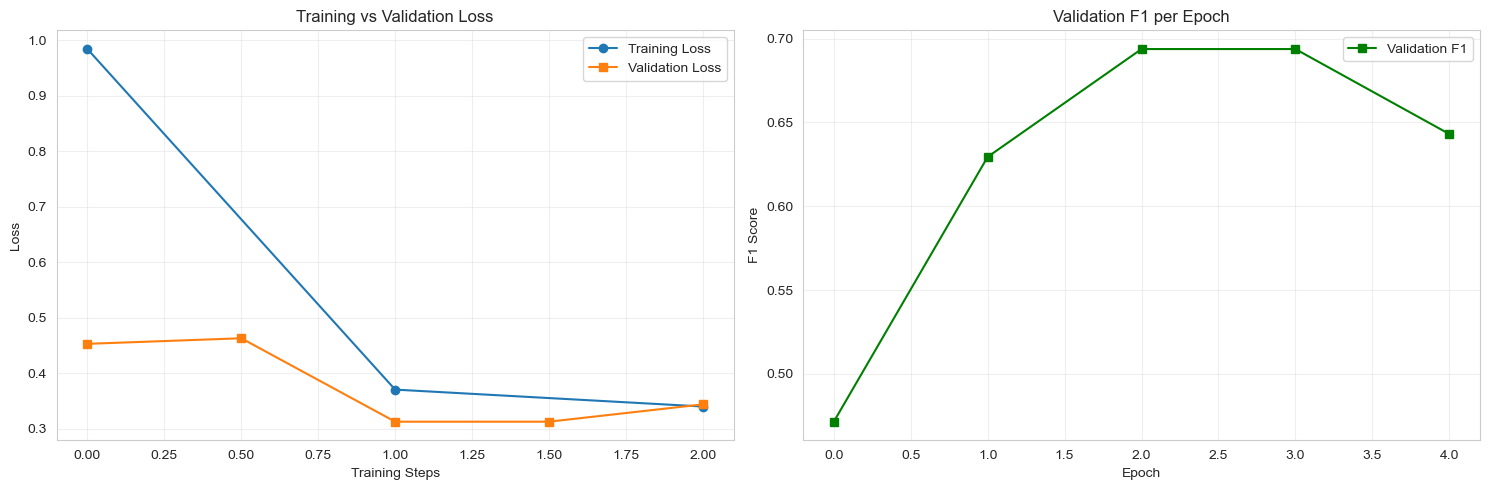

💾 Saved training history plot to models\bert_models\roberta_training_history.png


In [24]:
log_history = trainer.state.log_history

# Extract training & validation metrics
train_loss = [entry['loss'] for entry in log_history if 'loss' in entry]
eval_loss  = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]
eval_f1    = [entry['eval_f1'] for entry in log_history if 'eval_f1' in entry]

if train_loss and eval_loss:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # -------------------------
    # 1) Training loss (per step)
    # -------------------------
    ax1.plot(train_loss, label='Training Loss', marker='o')

    # -------------------------
    # 2) Validation loss (per epoch)
    # -------------------------
    ax1.plot(
        np.linspace(0, len(train_loss)-1, num=len(eval_loss)),
        eval_loss,
        label='Validation Loss',
        marker='s'
    )

    ax1.set_xlabel('Training Steps')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training vs Validation Loss')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # -------------------------
    # 3) Validation F1 per epoch
    # -------------------------
    ax2.plot(eval_f1, label='Validation F1', marker='s', color='green')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('F1 Score')
    ax2.set_title('Validation F1 per Epoch')
    ax2.grid(alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    
    save_path = BERT_MODELS_DIR / f"{current_model_name.lower()}_training_history.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"💾 Saved training history plot to {save_path}")
else:
    print("⚠️ Training history not available.")


---

## To Fine-tune Other Models:

**RoBERTa:**
1. Change `current_model_name = 'RoBERTa'` in section 4
2. Re-run from section 4 onwards

**XLM-RoBERTa:**
1. Change `current_model_name = 'XLM-RoBERTa'` in section 4
2. Re-run from section 4 onwards

All models will be saved separately in the `models/bert_models/` directory.

---

## 11. Multi-Model Training Runner (Optional)

This cell lets you fine-tune multiple Transformer backbones (BERT / RoBERTa / XLM-RoBERTa) in a loop and saves per-run artifacts + a compact CSV summary for paper tables.

**Prereqs:** Run sections 1→3 first (data loading/splitting/label mapping), and keep `MODEL_CHECKPOINTS`, `dataset_dict`, `MAX_LENGTH`, `BERT_MODELS_DIR`, `device`, and `compute_metrics` defined.

In [9]:
import csv
import gc
import json
import time
from pathlib import Path


def _model_slug(name: str) -> str:
    return (name or "").strip().lower().replace(" ", "_").replace("-", "_").replace("/", "_")


def _append_csv_row(csv_path: Path, row: dict) -> None:
    csv_path.parent.mkdir(parents=True, exist_ok=True)
    write_header = not csv_path.exists()
    with open(csv_path, "a", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=list(row.keys()))
        if write_header:
            writer.writeheader()
        writer.writerow(row)


def finetune_one_transformer(
    model_name: str,
    *,
    seed: int = RANDOM_STATE,
    num_epochs: int | None = None,
    train_batch_size: int | None = None,
    eval_batch_size: int | None = None,
    learning_rate: float = 2e-5,
    weight_decay: float = 0.01,
    max_length: int | None = None,
    max_train_samples: int | None = None,
    max_eval_samples: int | None = None,
) -> dict:
    if model_name not in MODEL_CHECKPOINTS:
        raise ValueError(
            f"Unknown model_name={model_name!r}. Choose one of: {list(MODEL_CHECKPOINTS.keys())}"
        )

    checkpoint = MODEL_CHECKPOINTS[model_name]
    run_tag = f"{_model_slug(model_name)}_seed{seed}_{int(time.time())}"
    run_output_dir = BERT_MODELS_DIR / f"{run_tag}_finetuned"
    final_model_dir = BERT_MODELS_DIR / f"{run_tag}_final"
    results_file = BERT_MODELS_DIR / f"{run_tag}_results.json"
    summary_csv = BERT_MODELS_DIR / "transformer_runs_summary.csv"

    # Defaults depend on RUN_PROFILE flags (defined earlier in the notebook)
    if max_length is not None:
        default_max_length = int(max_length)
    else:
        default_max_length = int(FAST_MAX_LENGTH) if FAST_MODE else (
            int(COMPARE_MAX_LENGTH) if COMPARE_MODE else int(MAX_LENGTH)
        )

    if num_epochs is not None:
        default_num_epochs = int(num_epochs)
    else:
        default_num_epochs = int(FAST_NUM_EPOCHS) if FAST_MODE else (
            int(COMPARE_NUM_EPOCHS) if COMPARE_MODE else 3
        )

    if train_batch_size is not None:
        default_train_bs = int(train_batch_size)
    else:
        default_train_bs = int(FAST_TRAIN_BATCH_SIZE) if FAST_MODE else (
            int(COMPARE_TRAIN_BATCH_SIZE) if COMPARE_MODE else 16
        )

    if eval_batch_size is not None:
        default_eval_bs = int(eval_batch_size)
    else:
        default_eval_bs = int(FAST_EVAL_BATCH_SIZE) if FAST_MODE else (
            int(COMPARE_EVAL_BATCH_SIZE) if COMPARE_MODE else 32
        )

    if max_train_samples is not None:
        default_max_train = max_train_samples
    else:
        if FAST_MODE:
            default_max_train = int(FAST_MAX_TRAIN_SAMPLES)
        elif COMPARE_MODE:
            default_max_train = COMPARE_MAX_TRAIN_SAMPLES
        else:
            default_max_train = None

    if max_eval_samples is not None:
        default_max_eval = max_eval_samples
    else:
        if FAST_MODE:
            default_max_eval = int(FAST_MAX_EVAL_SAMPLES)
        elif COMPARE_MODE:
            default_max_eval = COMPARE_MAX_EVAL_SAMPLES
        else:
            default_max_eval = None

    print(
        f"\n🚀 Fine-tuning: {model_name}\n"
        f"   checkpoint={checkpoint}\n"
        f"   profile={RUN_PROFILE}\n"
        f"   seed={seed}\n"
        f"   max_length={default_max_length}\n"
        f"   epochs={default_num_epochs}\n"
        f"   train_bs={default_train_bs}, eval_bs={default_eval_bs}\n"
        f"   output={run_output_dir.name}\n"
    )

    # Re-tokenize per model (tokenizers differ between backbones)
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)

    def tok_fn(examples):
        return tokenizer(
            examples["text"],
            padding="max_length",
            truncation=True,
            max_length=default_max_length,
        )

    tokenized = dataset_dict.map(
        tok_fn,
        batched=True,
        desc=f"Tokenizing ({model_name})",
    )

    if default_max_train is not None:
        tokenized["train"] = tokenized["train"].select(
            range(min(len(tokenized["train"]), int(default_max_train)))
        )
    if default_max_eval is not None:
        tokenized["validation"] = tokenized["validation"].select(
            range(min(len(tokenized["validation"]), int(default_max_eval)))
        )
        tokenized["test"] = tokenized["test"].select(
            range(min(len(tokenized["test"]), int(default_max_eval)))
        )

    model = AutoModelForSequenceClassification.from_pretrained(
        checkpoint,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id,
    )
    model.to(device)

    save_strategy = "no" if (FAST_MODE or COMPARE_MODE) else "epoch"
    load_best = False if (FAST_MODE or COMPARE_MODE) else True
    metric_for_best = None if (FAST_MODE or COMPARE_MODE) else "f1"
    callbacks = [] if (FAST_MODE or COMPARE_MODE) else [
        EarlyStoppingCallback(early_stopping_patience=2)
    ]

    args = TrainingArguments(
        output_dir=str(run_output_dir),
        num_train_epochs=default_num_epochs,
        per_device_train_batch_size=default_train_bs,
        per_device_eval_batch_size=default_eval_bs,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        eval_strategy="epoch",
        save_strategy=save_strategy,
        load_best_model_at_end=load_best,
        metric_for_best_model=metric_for_best,
        logging_dir=str(run_output_dir / "logs"),
        logging_steps=50,
        save_total_limit=2,
        seed=seed,
        fp16=torch.cuda.is_available(),
        report_to="none",
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized["train"],
        eval_dataset=tokenized["validation"],
        processing_class=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=callbacks,
    )

    train_result = trainer.train()
    val_results = trainer.evaluate(eval_dataset=tokenized["validation"])
    test_results = trainer.evaluate(eval_dataset=tokenized["test"])

    # Save model + tokenizer
    trainer.save_model(str(final_model_dir))
    tokenizer.save_pretrained(str(final_model_dir))

    results_dict = {
        "run_tag": run_tag,
        "model_name": model_name,
        "model_checkpoint": checkpoint,
        "profile": RUN_PROFILE,
        "validation_results": val_results,
        "test_results": test_results,
        "train_metrics": train_result.metrics,
        "training_args": {
            "num_epochs": default_num_epochs,
            "train_batch_size": default_train_bs,
            "eval_batch_size": default_eval_bs,
            "learning_rate": learning_rate,
            "weight_decay": weight_decay,
            "max_length": default_max_length,
            "seed": seed,
            "max_train_samples": default_max_train,
            "max_eval_samples": default_max_eval,
        },
        "saved_artifacts": {
            "output_dir": str(run_output_dir),
            "final_model_dir": str(final_model_dir),
        },
    }
    with open(results_file, "w", encoding="utf-8") as f:
        json.dump(results_dict, f, indent=2)

    row = {
        "run_tag": run_tag,
        "model_name": model_name,
        "checkpoint": checkpoint,
        "profile": RUN_PROFILE,
        "seed": seed,
        "eval_accuracy": test_results.get("eval_accuracy"),
        "eval_precision": test_results.get("eval_precision"),
        "eval_recall": test_results.get("eval_recall"),
        "eval_f1": test_results.get("eval_f1"),
        "eval_loss": test_results.get("eval_loss"),
        "max_length": default_max_length,
        "num_epochs": default_num_epochs,
        "train_batch_size": default_train_bs,
        "learning_rate": learning_rate,
        "final_model_dir": str(final_model_dir),
        "results_file": str(results_file),
    }
    _append_csv_row(summary_csv, row)

    print(f"✅ Saved: {final_model_dir.name}/")
    print(f"💾 Results JSON: {results_file.name}")
    print(f"📄 Summary CSV: {summary_csv.name}")

    # Cleanup GPU/CPU memory between runs
    del trainer, model, tokenizer, tokenized
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return results_dict


def finetune_many_transformers(
    model_names=("BERT", "RoBERTa", "XLM-RoBERTa"),
    seeds=(RANDOM_STATE,),
    **kwargs,
):
    all_results = []
    for m in model_names:
        for s in seeds:
            all_results.append(finetune_one_transformer(m, seed=s, **kwargs))
    return all_results


# NOTE:
# This cell intentionally defines helpers only.
# Use the dedicated "RUN BATCH" cell below to actually start training.


In [29]:
# === RUN BATCH (sequential) ===
# Tip: run this cell to train multiple models one-by-one using the runner above.
# It does NOT depend on `current_model_name`.

# Choose a profile for fair comparison across models
RUN_PROFILE = 'COMPARE'  # 'FAST' | 'COMPARE' | 'PAPER'
FAST_MODE = RUN_PROFILE.upper() == 'FAST'
COMPARE_MODE = RUN_PROFILE.upper() == 'COMPARE'
PAPER_MODE = RUN_PROFILE.upper() == 'PAPER'

print(f"🎛️  RUN_PROFILE set to: {RUN_PROFILE}")
print(f"   max_length default: {COMPARE_MAX_LENGTH if COMPARE_MODE else (FAST_MAX_LENGTH if FAST_MODE else MAX_LENGTH)}")
print(f"   epochs default: {COMPARE_NUM_EPOCHS if COMPARE_MODE else (FAST_NUM_EPOCHS if FAST_MODE else 3)}")

# Pick models to run sequentially
MODEL_LIST = (
    'BERT',
    'RoBERTa',
    # Add lightweight models if you want:
    # 'DistilBERT', 'DistilRoBERTa', 'ELECTRA-Small', 'BERT-Mini', 'BERT-Small',
 )
SEEDS = (42,)

# Optional overrides (leave as None to use profile defaults)
OVERRIDES = dict(
    num_epochs=None,
    max_length=None,
    max_train_samples=None,
    max_eval_samples=None,
    train_batch_size=None,
    eval_batch_size=None,
 )

print("\n🧪 Will run:")
print("   models:", MODEL_LIST)
print("   seeds:", SEEDS)
print("   overrides:", {k: v for k, v in OVERRIDES.items() if v is not None} or "<profile defaults>")

# Run sequential training (this can take a while in COMPARE/PAPER modes)
batch_results = finetune_many_transformers(
    model_names=MODEL_LIST,
    seeds=SEEDS,
    **OVERRIDES,
 )

print(f"\n✅ Done. Runs appended to: { (BERT_MODELS_DIR / 'transformer_runs_summary.csv').name }")

🎛️  RUN_PROFILE set to: COMPARE
   max_length default: 128
   epochs default: 3

🧪 Will run:
   models: ('BERT', 'RoBERTa')
   seeds: (42,)
   overrides: <profile defaults>

🚀 Fine-tuning: BERT
   checkpoint=bert-base-uncased
   profile=COMPARE
   seed=42
   max_length=128
   epochs=3
   train_bs=8, eval_bs=16
   output=bert_seed42_1769880355_finetuned



Tokenizing (BERT): 100%|██████████| 201/201 [00:00<00:00, 5599.72 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.531400,0.367236,0.885000,0.624871,0.635177,0.621345
2,0.308900,0.274089,0.900000,0.731893,0.827518,0.718235
3,0.161000,0.271192,0.925000,0.830385,0.843659,0.824118


✅ Saved: bert_seed42_1769880355_final/
💾 Results JSON: bert_seed42_1769880355_results.json
📄 Summary CSV: transformer_runs_summary.csv

🚀 Fine-tuning: RoBERTa
   checkpoint=roberta-base
   profile=COMPARE
   seed=42
   max_length=128
   epochs=3
   train_bs=8, eval_bs=16
   output=roberta_seed42_1769881070_finetuned



Tokenizing (RoBERTa): 100%|██████████| 201/201 [00:00<00:00, 4327.13 examples/s]
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.518400,0.392249,0.855000,0.602008,0.585237,0.624874
2,0.368900,0.379992,0.880000,0.661677,0.656091,0.683445
3,0.175600,0.302060,0.910000,0.797464,0.806964,0.789496


✅ Saved: roberta_seed42_1769881070_final/
💾 Results JSON: roberta_seed42_1769881070_results.json
📄 Summary CSV: transformer_runs_summary.csv

✅ Done. Runs appended to: transformer_runs_summary.csv


In [10]:
# === RERUN RoBERTa WITH CHECKPOINTS (for training-history figure) ===
# This reruns RoBERTa in a "log-friendly" mode so Hugging Face writes checkpoint folders
# containing trainer_state.json (needed to plot loss/F1 history).

RUN_PROFILE = 'PAPER'  # ensure save_strategy='epoch' inside finetune_one_transformer
FAST_MODE = RUN_PROFILE.upper() == 'FAST'
COMPARE_MODE = RUN_PROFILE.upper() == 'COMPARE'
PAPER_MODE = RUN_PROFILE.upper() == 'PAPER'

print(f"🎛️  RERUN profile set to: {RUN_PROFILE}")

MODEL_LIST = ('RoBERTa',)
SEEDS = (42,)

# Force hyperparams to match the COMPARE run as closely as possible, while still saving checkpoints.
OVERRIDES = dict(
    num_epochs=3,
    max_length=128,
    max_train_samples=None,
    max_eval_samples=None,
    train_batch_size=8,
    eval_batch_size=8,
)

rerun_results = finetune_many_transformers(
    model_names=MODEL_LIST,
    seeds=SEEDS,
    **OVERRIDES,
)

roberta_run_tag_for_history = [r['run_tag'] for r in rerun_results if r['model_name'] == 'RoBERTa'][-1]
print("\n✅ RoBERTa rerun complete")
print("ROBERA_RUN_TAG_FOR_HISTORY=", roberta_run_tag_for_history)
print("Now generate the figure from trainer_state.json using scripts/generate_training_history_figure.py")


🎛️  RERUN profile set to: PAPER

🚀 Fine-tuning: RoBERTa
   checkpoint=roberta-base
   profile=PAPER
   seed=42
   max_length=128
   epochs=3
   train_bs=8, eval_bs=8
   output=roberta_seed42_1769889004_finetuned



Tokenizing (RoBERTa): 100%|██████████| 201/201 [00:00<00:00, 4903.99 examples/s]
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.484800,0.345861,0.880000,0.631288,0.619579,0.643866
2,0.355900,0.332391,0.875000,0.637531,0.618061,0.686303
3,0.181800,0.351019,0.900000,0.794691,0.811760,0.788067


✅ Saved: roberta_seed42_1769889004_final/
💾 Results JSON: roberta_seed42_1769889004_results.json
📄 Summary CSV: transformer_runs_summary.csv

✅ RoBERTa rerun complete
ROBERA_RUN_TAG_FOR_HISTORY= roberta_seed42_1769889004
Now generate the figure from trainer_state.json using scripts/generate_training_history_figure.py
